# ATLX (Bao et al. 2022) and Co-LSTM (Behera et al. 2021) Implementation

In [1]:
%matplotlib inline
%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dropout, LSTM, Bidirectional, Attention, Dense, Activation, Flatten, Conv1D, MaxPool1D
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datetime import datetime

## Data Preprocessing

In [2]:
# embeddings allows for implementation of separating sentences into aspects, hence "aspect embeddings"
# used in embeddings layer of the NN archictecture
# PAPER INNOVATION: sentiment induction - domain-specific embeddings 
# (in this case, social media since the embeddings are from twitter posts)
embeddings_dict = {}
dim = 100
f = open('datastories.twitter.100d.txt', "r", encoding="utf-8")
for i, line in enumerate(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dict[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_dict))

Found 658125 word vectors.


In [3]:
# Cleans embeddings (e.g. padding for irrelevant values, marking unknown characters)
def get_embeddings(vectors, dim):
    vocab_size = len(vectors)
    print('Loaded %s word vectors.' % vocab_size)
    wv_map = {}
    pos = 0
    # +1 for zero padding token and +1 for unk
    emb_matrix = np.ndarray((vocab_size + 2, dim), dtype='float32')
    for i, (word, vector) in enumerate(vectors.items()):
        pos = i + 1
        wv_map[word] = pos
        emb_matrix[pos] = vector
    
    # add unknown token
    pos += 1
    wv_map["<unk>"] = pos
    emb_matrix[pos] = np.random.uniform(low=-0.05, high=0.05, size=dim)
    
    return emb_matrix, wv_map

In [4]:
embeddings, word_indices = get_embeddings(embeddings_dict, dim)

Loaded 658125 word vectors.


In [5]:
# load data w features: ID, sentiment, message
# PAPER INNOVATION: sentiment induction - data domain-specific to social media
def load_data(filename):
    d = pd.read_csv('datastories-semeval2017-task4/dataset/Subtask_A/downloaded/'+filename, sep='\t', header=3, 
                   names=['ID', 'sentiment', 'message'], encoding='utf-8')
    d['message'] = d.message.str.replace("\\u002c", ',', regex=False)
    d['message'] = d.message.str.replace("\\u2019", '\'', regex=False)
    d['message'] = d.message.str.replace('\\""', '"', regex=False)
    return d

In [6]:
# train data
data_16 = load_data('twitter-2016train-A.tsv')
data_15 = load_data('twitter-2015train-A.tsv')
data_13 = load_data('twitter-2013train-A.tsv')
print(data_13.message.values[0])
data = pd.concat([data_13, data_15, data_16]).reset_index(drop=True)
data

# drop duplicates
data = data.drop_duplicates(keep='first').reset_index(drop=True)
data

Tehran, Mon Amour: Obama Tried to Establish Ties with the Mullahs http://t.co/TZZzrrKa via @PJMedia_com No Barack Obama - Vote Mitt Romney


,ID,sentiment,message
0,262682041215234048,neutral,"Tehran, Mon Amour: Obama Tried to Establish Ti..."
1,264229576773861376,neutral,I sat through this whole movie just for Harry ...
2,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...
3,264094586689953794,negative,"Talking about ACT's && SAT's, deciding where I..."
4,212392538055778304,neutral,"Why is ""Happy Valentines Day"" trending? It's o..."
...,...,...,...
15498,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...
15499,639979760735662080,neutral,everyone who sat around me at metlife was so a...
15500,640196838260363269,neutral,what giants or niners fans would wanna go to t...
15501,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs...


In [7]:
# drop neutral sentiment values for comparison with Co-LSTM
data = data.loc[data["sentiment"] != 'neutral']
data

,ID,sentiment,message
2,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...
3,264094586689953794,negative,"Talking about ACT's && SAT's, deciding where I..."
5,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla..."
8,263398998675693568,positive,@oluoch @victor_otti @kunjand I just watched i...
9,263650552167157762,positive,One of my best 8th graders Kory was excited af...
...,...,...,...
15495,639166904813223937,positive,Heading up to MetLife tomorrow for the Jets game
15496,639295526995890177,positive,Going to MetLife tomorrow but not to see the b...
15497,639804828739346432,positive,It's the first Football Friday of the year. Th...
15498,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...


In [8]:
# test data
test_16 = load_data('twitter-2016devtest-A.tsv')
test_15 = load_data('twitter-2015test-A.tsv')
test_13 = load_data('twitter-2013test-A.tsv')
data_test = pd.concat([test_13, test_15, test_16]).reset_index(drop=True)
data_test = data_test.drop_duplicates(keep='first').reset_index(drop=True)
data_test

,ID,sentiment,message
0,171874368908050432,neutral,"Excuse the connectivity of this live stream, f..."
1,256010056942903296,positive,Show your LOVE for your local field & it might...
2,253809989599232000,neutral,"Milton on Bolton Wanderers 2 v 2 Leeds United,..."
3,261776619146985472,positive,@firecore Can you tell me when an update for t...
4,264143999374356481,positive,"@Heavensbasement The Crown, Filthy McNastys, K..."
...,...,...,...
7911,639016598477651968,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...
7912,640276909633486849,neutral,Rib injury for Zlatan against Russia is a big ...
7913,640296841725235200,neutral,Noooooo! I was hoping to see Zlatan being Zlat...
7914,641017384908779520,neutral,@Fronsoir Zlatan has never done it on a wet Tu...


In [9]:
# drop neutral sentiment values for comparison with Co-LSTM
data_test = data_test.loc[data_test["sentiment"] != 'neutral']
data_test

,ID,sentiment,message
1,256010056942903296,positive,Show your LOVE for your local field & it might...
3,261776619146985472,positive,@firecore Can you tell me when an update for t...
4,264143999374356481,positive,"@Heavensbasement The Crown, Filthy McNastys, K..."
6,264088575476391936,positive,My #cre blog Oklahoma Per Square Foot returns ...
8,263720820428394496,negative,Trey Burke has been suspended for the Northern...
...,...,...,...
7903,637735358126555136,positive,@rhysllew26 I reckon we'll get him next season...
7905,638018562334916609,positive,Wonder if Zlatan will be a United player come ...
7906,638033582112534529,negative,"Today United should have done better, the refe..."
7907,638090040254574592,negative,If there is a silver lining this shows LVG if ...


In [10]:
# ekphrasis is a text processing tool made specifically for social media sites like twitter and facebook
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [11]:
# code from https://github.com/cbaziotis/ekphrasis
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    annotate={},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

C:\Users\andre\miniconda3\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


C:\Users\andre\miniconda3\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [12]:
test_id = 5
print(data['message'].values[test_id])
" ".join(text_processor.pre_process_doc(data['message'].values[test_id]))

@MsSheLahY I didnt want to just pop up... but yep we have chapel hill next wednesday you should come.. and shes great ill tell her you asked


'<user> i didnt want to just pop up . . . but yep we have chapel hill next wednesday you should come . . and shes great ill tell her you asked'

In [13]:
# represent train posts as concatenated work vectors
preprocessed = []
vectors = []
unknown = 0
dim = embeddings.shape[1]
for _,row in tqdm(data.iterrows(), total=data.shape[0]):
    ekphrased = text_processor.pre_process_doc(row.message)
    preprocessed.append(ekphrased)
    vec = np.zeros([dim])
    for word in ekphrased:
        if word in embeddings_dict:
            vec += embeddings_dict[word]
        else:
            unknown += 1
    vectors.append(vec)
print(unknown, 'words could not be assigned to vector')

100%|████████████████████████████████████████████████████████████████████████████| 8939/8939 [00:05<00:00, 1635.87it/s]

749 words could not be assigned to vector


In [14]:
data['preprocessed'] = preprocessed
X_train_vector = vectors
data

C:\Users\andre\AppData\Local\Temp\ipykernel_15044\2210259397.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['preprocessed'] = preprocessed


,ID,sentiment,message,preprocessed
2,264105751826538497,positive,with J Davlar 11th. Main rivals are team Polan...,"[with, j, davlar, 1, 1, th, ., main, rivals, a..."
3,264094586689953794,negative,"Talking about ACT's && SAT's, deciding where I...","[talking, about, act, ', s, &, &, sat, ', s, ,..."
5,254941790757601280,negative,"They may have a SuperBowl in Dallas, but Dalla...","[they, may, have, a, superbowl, in, dallas, ,,..."
8,263398998675693568,positive,@oluoch @victor_otti @kunjand I just watched i...,"[<user>, <user>, <user>, i, just, watched, it,..."
9,263650552167157762,positive,One of my best 8th graders Kory was excited af...,"[one, of, my, best, 8, th, graders, kory, was,..."
...,...,...,...,...
15495,639166904813223937,positive,Heading up to MetLife tomorrow for the Jets game,"[heading, up, to, metlife, tomorrow, for, the,..."
15496,639295526995890177,positive,Going to MetLife tomorrow but not to see the b...,"[going, to, metlife, tomorrow, but, not, to, s..."
15497,639804828739346432,positive,It's the first Football Friday of the year. Th...,"[it, ', s, the, first, football, friday, of, t..."
15498,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLif...,"[<user>, ok, good, to, know, ., punting, at, m..."


In [15]:
# represent test posts as concatenated work vectors
preprocessed = []
vectors = []
unknown = 0
dim = embeddings.shape[1]
for _,row in tqdm(data_test.iterrows(), total=data_test.shape[0]):
    ekphrased = text_processor.pre_process_doc(row.message)
    preprocessed.append(ekphrased)
    vec = np.zeros([dim])
    for word in ekphrased:
        if word in embeddings_dict:
            vec += embeddings_dict[word]
        else:
            unknown += 1
    vectors.append(vec)
print(unknown, 'words could not be assigned to vector')

100%|████████████████████████████████████████████████████████████████████████████| 4741/4741 [00:02<00:00, 1819.64it/s]

409 words could not be assigned to vector


In [16]:
data_test['preprocessed'] = preprocessed
X_test_vector = vectors
data_test

C:\Users\andre\AppData\Local\Temp\ipykernel_15044\316191757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['preprocessed'] = preprocessed


,ID,sentiment,message,preprocessed
1,256010056942903296,positive,Show your LOVE for your local field & it might...,"[show, your, love, for, your, local, field, &,..."
3,261776619146985472,positive,@firecore Can you tell me when an update for t...,"[<user>, can, you, tell, me, when, an, update,..."
4,264143999374356481,positive,"@Heavensbasement The Crown, Filthy McNastys, K...","[<user>, the, crown, ,, filthy, mcnastys, ,, k..."
6,264088575476391936,positive,My #cre blog Oklahoma Per Square Foot returns ...,"[my, cre, blog, oklahoma, per, square, foot, r..."
8,263720820428394496,negative,Trey Burke has been suspended for the Northern...,"[trey, burke, has, been, suspended, for, the, ..."
...,...,...,...,...
7903,637735358126555136,positive,@rhysllew26 I reckon we'll get him next season...,"[<user>, i, reckon, we, will, get, him, next, ..."
7905,638018562334916609,positive,Wonder if Zlatan will be a United player come ...,"[wonder, if, zlatan, will, be, a, united, play..."
7906,638033582112534529,negative,"Today United should have done better, the refe...","[today, united, should, have, done, better, ,,..."
7907,638090040254574592,negative,If there is a silver lining this shows LVG if ...,"[if, there, is, a, silver, lining, this, shows..."


In [17]:
sentiment_id = {'positive': 0, 'negative': 1}
y_train = to_categorical(data.sentiment.apply(lambda x: sentiment_id[x]))
y_test = to_categorical(data_test.sentiment.apply(lambda x: sentiment_id[x]))
max_length = max(data.preprocessed.apply(lambda x: len(x)))
def padded_index_vector(df):
    X = df.preprocessed.apply(lambda x: [word_indices[word] if word in word_indices else word_indices['<unk>'] for word in x]).values
    X = [np.pad(np.array(x), (0, max_length -len(x)), 'constant', constant_values=(0,0)) for x in X]
    X = np.stack(X)
    return X
X_train = padded_index_vector(data)
X_test = padded_index_vector(data_test)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

## Models

In [18]:
# attention layer: THIS IS THE HEART OF THE PAPER'S INNOVATION, ATTENTION BASED ON ASPECT EMBEDDINGS
# source: https://stackoverflow.com/questions/62948332/how-to-add-attention-layer-to-a-bi-lstm/62949137#62949137
class Attention(tf.keras.layers.Layer):

    def __init__(self, return_sequences=True, name=None, **kwargs):
        super(Attention, self).__init__(name=name)
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
    
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                           initializer="glorot_uniform", trainable=True)
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                           initializer="glorot_uniform", trainable=True)
    
        super(Attention, self).build(input_shape)

    def call(self, x):
    
        e = tf.keras.activations.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.activations.softmax(e, axis=1)
        output = x * a
    
        if self.return_sequences:
            return output
        return tf.keras.backend.sum(output, axis=1)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'return_sequences': self.return_sequences 
        })
        return config

In [19]:
# embeddings layer
def embeddings_layer(max_length, embeddings, samples, trainable=False, masking=False,
                     scale=False, normalize=False):
    if scale:
        embeddings = preprocessing.scale(embeddings)
    if normalize:
        embeddings = preprocessing.normalize(embeddings)

    vocab_size = embeddings.shape[0]
    embedding_size = embeddings.shape[1]

    _embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_size,
        input_length=max_length if max_length > 0 else None,
        trainable=trainable,
        mask_zero=masking if max_length > 0 else False,
        weights=[embeddings]
    )

    return _embedding
emb_layer = embeddings_layer(max_length, embeddings, len(data))

In [20]:
# method 1 - ATLX
model = Sequential()
model.add(emb_layer)
model.add(Dropout(0.3))
rnn = LSTM(64, return_sequences=True, dropout=0.3)
model.add(Bidirectional(rnn))
model.add(Dropout(0.3))
model.add(Bidirectional(rnn))
model.add(Dropout(0.3))
model.add(Attention(name='attention_weight'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(len(data.sentiment.unique()), activity_regularizer=L2(0.0001)))
model.add(Activation('softmax'))

# clipnorm=1 --> gradient of each weight is no higher than 1
model.compile(optimizer=Adam(clipnorm=1, lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1099, 100)         65812700  
                                                                 
 dropout (Dropout)           (None, 1099, 100)         0         
                                                                 
 bidirectional (Bidirectiona  (None, 1099, 128)        84480     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 1099, 128)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 1099, 128)        98816     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 1099, 128)         0

C:\Users\andre\miniconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [22]:
# method 2 - Co-LSTM
model1 = Sequential()
model1.add(Embedding(embeddings.shape[0], 100, input_length=max_length))
model1.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
model1.add(MaxPool1D(2))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(64, return_sequences=True))
model1.add(Flatten())
model1.add(Dense(64))
model1.add(Dense(len(data.sentiment.unique()), activity_regularizer=L2(0.0001)))
model1.add(Activation('sigmoid'))

# clipnorm=1 --> gradient of each weight is no higher than 1
model1.compile(optimizer=Adam(clipnorm=1, lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1099, 100)         65812700  
                                                                 
 conv1d (Conv1D)             (None, 1092, 32)          25632     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 546, 32)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 546, 64)           24832     
                                                                 
 lstm_2 (LSTM)               (None, 546, 64)           33024     
                                                                 
 flatten_1 (Flatten)         (None, 34944)             0         
                                                      

In [23]:
logdir1="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(log_dir=logdir1)

# Training

In [24]:
epochs = 25
validation_freq = 1

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), validation_freq=validation_freq, epochs=epochs,
                    batch_size=50, use_multiprocessing=True, workers=20, shuffle=True, callbacks=[tensorboard_callback])
model.save('model_1.h5', save_format='h5')

Epoch 1/25
161/161 [==============================] - 1038s 6s/step - loss: 0.5437 - accuracy: 0.7392 - val_loss: 0.5620 - val_accuracy: 0.7528
Epoch 2/25
161/161 [==============================] - 1048s 7s/step - loss: 0.4955 - accuracy: 0.7569 - val_loss: 0.4125 - val_accuracy: 0.8210
Epoch 3/25
161/161 [==============================] - 1049s 7s/step - loss: 0.4385 - accuracy: 0.7933 - val_loss: 0.3936 - val_accuracy: 0.8221
Epoch 4/25
161/161 [==============================] - 1117s 7s/step - loss: 0.4185 - accuracy: 0.8067 - val_loss: 0.3639 - val_accuracy: 0.8456
Epoch 5/25
161/161 [==============================] - 1130s 7s/step - loss: 0.3948 - accuracy: 0.8216 - val_loss: 0.3414 - val_accuracy: 0.8535
Epoch 6/25
161/161 [==============================] - 1162s 7s/step - loss: 0.3871 - accuracy: 0.8241 - val_loss: 0.3565 - val_accuracy: 0.8456
Epoch 7/25
161/161 [==============================] - 1262s 8s/step - loss: 0.3842 - accuracy: 0.8251 - val_loss: 0.3302 - val_accuracy:

In [26]:
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), validation_freq=validation_freq, epochs=epochs,
                    batch_size=50, use_multiprocessing=True, workers=20, shuffle=True, callbacks=[tensorboard_callback1])
model1.save('model_2.h5', save_format='h5')

Epoch 1/25
161/161 [==============================] - 280s 2s/step - loss: 0.4849 - accuracy: 0.7728 - val_loss: 0.3984 - val_accuracy: 0.8233
Epoch 2/25
161/161 [==============================] - 267s 2s/step - loss: 0.1911 - accuracy: 0.9255 - val_loss: 0.3771 - val_accuracy: 0.8501
Epoch 3/25
161/161 [==============================] - 293s 2s/step - loss: 0.0513 - accuracy: 0.9833 - val_loss: 0.5154 - val_accuracy: 0.8333
Epoch 4/25
161/161 [==============================] - 296s 2s/step - loss: 0.0119 - accuracy: 0.9990 - val_loss: 0.6661 - val_accuracy: 0.8311
Epoch 5/25
161/161 [==============================] - 298s 2s/step - loss: 0.0092 - accuracy: 0.9996 - val_loss: 0.6178 - val_accuracy: 0.8367
Epoch 6/25
161/161 [==============================] - 294s 2s/step - loss: 0.0065 - accuracy: 0.9996 - val_loss: 0.5649 - val_accuracy: 0.8367
Epoch 7/25
161/161 [==============================] - 292s 2s/step - loss: 0.0056 - accuracy: 0.9996 - val_loss: 0.5765 - val_accuracy: 0.8378

In [44]:
with open('history.txt', 'w') as f:
    for key, value in history.history.items(): 
        f.write('%s:%s\n' % (key, value))
        
with open('history1.txt', 'w') as f:
    for key, value in history1.history.items(): 
        f.write('%s:%s\n' % (key, value))

## Evaluation

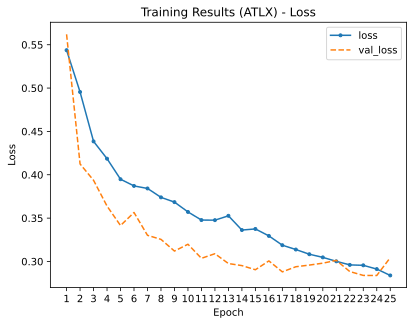

In [28]:
fig, ax = plt.subplots()

ax.plot(list(range(1, epochs+1)), history.history['loss'], marker=".", label="loss")
ax.plot(list(range(1, epochs+1)), history.history['val_loss'], linestyle="--", label="val_loss")
ax.set_xticks(list(range(1, epochs+1)))
#ax.set_ylim(.8, 1.01)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training Results (ATLX) - Loss')

fig.savefig("ATLX_loss.png", bbox_inches="tight", transparent=True, facecolor=fig.get_facecolor())

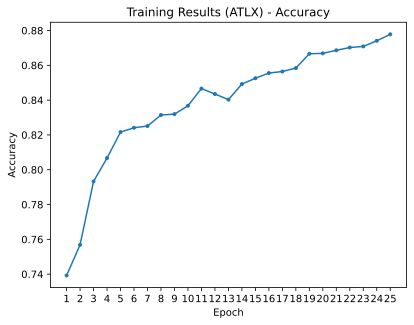

In [29]:
fig, ax = plt.subplots()

ax.plot(list(range(1, epochs+1)), history.history['accuracy'], marker='.')
ax.set_xticks(list(range(1, epochs+1)))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Results (ATLX) - Accuracy')

fig.savefig("ATLX_accuracy.png", bbox_inches="tight", transparent=True, facecolor=fig.get_facecolor())

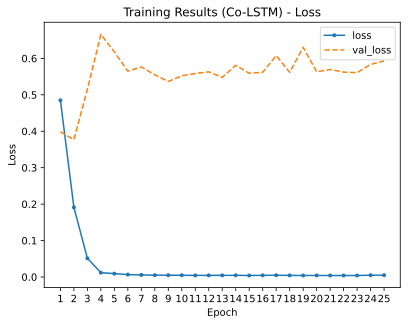

In [30]:
fig, ax = plt.subplots()

ax.plot(list(range(1, epochs+1)), history1.history['loss'], marker=".", label="loss")
ax.plot(list(range(1, epochs+1)), history1.history['val_loss'], linestyle="--", label="val_loss")
ax.set_xticks(list(range(1, epochs+1)))
#ax.set_ylim(.8, 1.01)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training Results (Co-LSTM) - Loss')

fig.savefig("Co-LSTM_loss.png", bbox_inches="tight", transparent=True, facecolor=fig.get_facecolor())

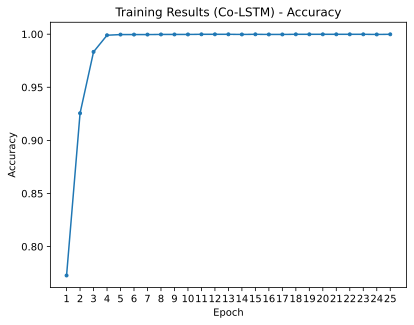

In [31]:
fig, ax = plt.subplots()

ax.plot(list(range(1, epochs+1)), history1.history['accuracy'], marker='.')
ax.set_xticks(list(range(1, epochs+1)))
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Training Results (Co-LSTM) - Accuracy')

fig.savefig("Co_LSTM_loss.png", bbox_inches="tight", transparent=True, facecolor=fig.get_facecolor())

In [45]:
%tensorboard --logdir logs

In [32]:
predictions = model.predict(X_test)

149/149 [==============================] - 104s 667ms/step


In [33]:
testIndex = 28
print('prediction:', predictions[testIndex])
print('true:', y_test[testIndex])

prediction: [0.22835128 0.7716487 ]
true: [0. 1.]


In [34]:
# compute accuracy
accuracy_count = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i]) == np.argmax(y_test[i]):
        accuracy_count += 1
accuracy = accuracy_count / len(predictions)
print('Accuracy (ATLX):', accuracy)

Accuracy (ATLX): 0.8430710820502004


In [35]:
predictions = model1.predict(X_test)

149/149 [==============================] - 34s 225ms/step


In [36]:
testIndex = 28
print('prediction:', predictions[testIndex])
print('true:', y_test[testIndex])

prediction: [0.4747035  0.52330863]
true: [0. 1.]


In [37]:
# compute accuracy
accuracy_count = 0
for i in range(len(predictions)):
    if np.argmax(predictions[i]) == np.argmax(y_test[i]):
        accuracy_count += 1
accuracy = accuracy_count / len(predictions)
print('Accuracy (Co-LSTM):', accuracy)

Accuracy (Co-LSTM): 0.8065808901075723


## References

Bao, L., Lambert, P., & Badia, T. (2022). Improving aspect-based neural sentiment classification with lexicon enhancement, attention regularization and sentiment induction. Natural Language Engineering, 1-30. doi:10.1017/S1351324922000432

Behera, R. K., Jena, M., Rath, S. K., & Misra, S. (2021). Co-LSTM: Convolutional LSTM model for sentiment analysis in Social Big Data. Information Processing & Management, 58(1), 102435. https://doi.org/10.1016/j.ipm.2020.102435